First we import the packages will be used. And we will use entire text of H. G. Wells’ The Time Machine as dataset.


In [1]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


## 1. RNN Model

Then we Create a class to define RNN model.

'save_hyperparameters()' is used to specify which init arguments should be saved in the checkpoint file to be used to instantiate the model from the checkpoint later


In [2]:
class RNNScratch(d2l.Module):  # @save
    """The RNN model implemented from scratch."""

    def __init__(self, num_inputs, num_hiddens, sigma=0.01):  # d,h
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)  # d,h
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))


Forward function is to compute the hidden state and output.


In [3]:
@d2l.add_to_class(RNNScratch)  # @save
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)   n*h
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                            device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs) T,n,d
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                           torch.matmul(state, self.W_hh) + self.b_h)  # n,h
        outputs.append(state)
    return outputs, state


Define the batchsize of minibatch of input sequences.


In [4]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100  # n,d,h,T
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)


Check whether the RNN model produces results of the correct shapes to ensure that the dimensionality of the hidden state remains unchanged.


In [5]:
def check_len(a, n):  # @save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'


def check_shape(a, shape):  # @save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
        f'tensor\'s shape {a.shape} != expected shape {shape}'


check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))


## 2. RNN-based Language Model

Defines an RNN-based language model. When training language models, the inputs and outputs are from the same vocabulary.

Note that we use perplexity to evaluate the model, which ensures that sequences of different length are comparable.


In [6]:
class RNNLMScratch(d2l.Classifier):  # @save
    """The RNN-based language model implemented from scratch."""
    # inputs and outputs have the same dimension, which is equal to the vocabulary size.

    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)  # h,d
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)


## 3. One-hot encoding

We cannot use a scalar value to represent token here. For expample, The 45th and 46th words in our vocabulary happen to be “their” and “said”, whose meanings are not remotely similar.

When dealing with such categorical data, the most common strategy is to represent each item by an one-hot encoding.


In [7]:
F.one_hot(torch.tensor([0, 2]), 5)


tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [8]:
@d2l.add_to_class(RNNLMScratch)  # @save
def one_hot(self, X):   # batch_size,num_steps (n,T)
    # Output shape: (num_steps, batch_size, vocab_size) T,n,d
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)


## 4. Transforming RNN Outputs


The language model uses a fully connected output layer to transform RNN outputs into token predictions at each time step. To make sure same dimensionality if input and output.


In [9]:
@d2l.add_to_class(RNNLMScratch)  # @save
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]  # T martrix with shape (n, d)
    return torch.stack(outputs, 1)  # second dimension
    # concatenate many 2-dimensional tensors into a 3-dimensional tensor (n, T, d)
    #
    # a=tensor([[1, 2, 3],
    #         [4, 5, 6],
    #         [7, 8, 9]])
    # b=tensor([[11, 22, 33],
    #         [44, 55, 66],
    #         [77, 88, 99]])
    # c=tensor([[[ 1,  2,  3],
    #         [11, 22, 33]],

    #         [[ 4,  5,  6],
    #         [44, 55, 66]],

    #         [[ 7,  8,  9],
    #         [77, 88, 99]]])


@d2l.add_to_class(RNNLMScratch)  # @save
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)  # prediction


Check whether the forward computation produces outputs with the correct shape.


In [10]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))


## 5. Gradient Clipping

RNN model always suffers the issues about vanishing and exploding gradients.

The gradient descent method sometimes goes in the wrong direction, so we want to limit the size of gradients to prevent big mistakes. However, we rarely get large gradients, so we derive a clipping method to shrink the gradient if it exceeds the threshold.


In [11]:
@d2l.add_to_class(d2l.Trainer)  # @save
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm   # norm of gradient will be bounded


# 6. Training


Using The Time Machine dataset (data), we train a character-level language model (model) based on the RNN (rnn) implemented from scratch.


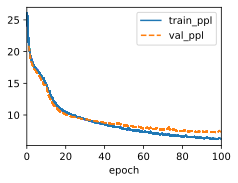

In [12]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


## 7. Decoding


Once a language model has been learned, we can use it not only to predict the next token but to continue predicting each subsequent token, treating the previously predicted token as though it were the next token in the input.

Warm-up: When looping through the characters in prefix, we keep passing the hidden state to the next time step but do not generate any output.


In [13]:
@d2l.add_to_class(RNNLMScratch)  # @save
def predict(self, prefix, num_preds, vocab, device=None):
    # prefix: input text
    state, outputs = None, [vocab[prefix[0]]]  # mapping the first string to vocab index
    for i in range(len(prefix) + num_preds - 1):
        # use the previous prediction as input
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:
            # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
            # categorizing prediction and convert to integer
    return ''.join([vocab.idx_to_token[i] for i in outputs])


In [14]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())


'it has of the ment and the'

The result seems confusing...
